In [1]:
""" 
The purpose of this script is to further generalize the script to 
adapt to different experiments and temperature at the same time
"""
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize,sys
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl

In [2]:

########################     Global settings!!!
On_HPC = False 
rows_per_file = 3;  Scan_end_end = 6;
purpose_i = "Redo_GoodFitExp5_40degC"
Runshort  =   False                    # a long run or a quick test


if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify
Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters


if On_HPC:                          # Run on HPC
    Path_csv = f"InputData/{purpose_i}/" 
    Path_NiallDMA = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = Path_csv +  para_csv
else:
    import sys  
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_NiallDMA = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
    Para_file = BasicPath+f'/Get_Random_sets/{purpose_i}/'+para_csv
    
if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);
# import all functions 
from Fun_P2 import * 

# Load the random file
parameter_names, combinations = load_combinations_from_csv(Para_file)


pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1
""" para_dict_Same = {
   "Total ageing cycles":int(tot_cyc), # 
   "Ageing cycles between RPT":int(cyc_age), # 
   "Update cycles for ageing": int(cyc_age),
} """
# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 3


In [3]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    #"RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];

# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [4]:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  
Return_Sol=False;   Check_Small_Time=True;

my_dict_1Cyc,Sol_RPT,Sol_0,Call_1Cyc = Run_P2_Excel (
    Para_dict_list[2],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time
) 


Start Now! Scan 3.


Read Exp-5 - Cell A RPT 0
Read Exp-5 - Cell A RPT 1
Read Exp-5 - Cell A RPT 2
Read Exp-5 - Cell A RPT 3
Read Exp-5 - Cell A RPT 4
Read Exp-5 - Cell A RPT 5
Read Exp-5 - Cell A RPT 6
Read Exp-5 - Cell A RPT 7
Read Exp-5 - Cell A RPT 8
Read Exp-5 - Cell A RPT 9
Read Exp-5 - Cell A RPT 10
Read Exp-5 - Cell A RPT 11
Read Exp-5 - Cell A RPT 12
Read Exp-5 - Cell A RPT 13
Read Exp-5 - Cell A RPT 14
Read Exp-5 - Cell A RPT 15
Read Exp-5 - Cell B RPT 0
Read Exp-5 - Cell B RPT 1
Read Exp-5 - Cell B RPT 2
Read Exp-5 - Cell B RPT 3
Read Exp-5 - Cell B RPT 4
Read Exp-5 - Cell B RPT 5
Read Exp-5 - Cell B RPT 6
Read Exp-5 - Cell B RPT 7
Read Exp-5 - Cell B RPT 8
Read Exp-5 - Cell B RPT 9
Read Exp-5 - Cell B RPT 10
Read Exp-5 - Cell B RPT 11
Read Exp-5 - Cell B RPT 12
Read Exp-5 - Cell B RPT 13
Read Exp-5 - Cell B RPT 14
Read Exp-5 - Cell B RPT 15
Read Exp-5 - Cell C RPT 0
Read Exp-5 - Cell C RPT 1
Read Exp-5 - Cell C RPT 2
Read Exp-5 - Cell C RPT 3
Read Exp-5 - Cell C RPT 4
Read Exp-5 - Cell C RPT 5


At t = 1280.87 and h = 1.71599e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish break-in cycle within 1 minute, 8 seconds
Scan 3: Finish post-process for break-in cycle within 191.105 ms


At t = 138.777 and h = 7.61798e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 138.777 and h = 1.18717e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.1336 and h = 9.3305e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.1336 and h = 1.10036e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.1337 and h = 8.47838e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 78.3703 and h = 5.15549e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 78.3703 and h = 5.15307e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 78.3703 and h = 5.15537e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.666 and h = 8.58492e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.6661 and h = 7.17435e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 3: Finish for No.0 ageing cycles within 13 minutes, 5 seconds
Scan 3: Finish post-process for No.26 ageing cycles within 506.827 ms


At t = 121.98 and h = 5.24404e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 121.98 and h = 5.24382e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.6183 and h = 8.28172e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.6181 and h = 2.86115e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.6181 and h = 2.94043e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.2739 and h = 4.0921e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.2741 and h = 3.44926e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.2741 and h = 5.95627e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 60.9344 and h = 9.46991e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 60.9345 and h = 7.54515e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.26 ageing cycles within 12 minutes, 31 seconds
Scan 3: Finish post-process for No.52 ageing cycles within 160.644 ms


At t = 110.925 and h = 1.56427e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.925 and h = 4.15726e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.925 and h = 3.97971e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.9255 and h = 8.7675e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.6505 and h = 3.02192e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.6503 and h = 1.16187e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.6504 and h = 7.52144e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.6503 and h = 1.07651e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.3856 and h = 1.05614e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.3852 and h = 4.90888e-15, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.52 ageing cycles within 13 minutes, 43 seconds
Scan 3: Finish post-process for No.78 ageing cycles within 159.890 ms


At t = 743.637 and h = 1.79179e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 743.638 and h = 3.88279e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 274.753 and h = 2.00495e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 274.753 and h = 1.75549e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 124.752 and h = 8.56247e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.78 RPT cycles within 1 minute, 25 seconds
Scan 3: Finish post-process for No.78 RPT cycles within 138.213 ms


At t = 99.5377 and h = 9.51442e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.5378 and h = 8.09356e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.5377 and h = 3.53889e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.78 ageing cycles within 10 minutes, 54 seconds
Scan 3: Finish post-process for No.104 ageing cycles within 159.325 ms


At t = 93.0087 and h = 9.26021e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.0087 and h = 8.34097e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.0087 and h = 9.61556e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.104 ageing cycles within 11 minutes, 3 seconds
Scan 3: Finish post-process for No.130 ageing cycles within 231.370 ms


At t = 86.0781 and h = 1.37816e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.0786 and h = 8.66967e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 86.0786 and h = 1.08238e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.130 ageing cycles within 11 minutes, 7 seconds
Scan 3: Finish post-process for No.156 ageing cycles within 196.053 ms


At t = 517.098 and h = 9.29756e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 517.096 and h = 1.68224e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 230.117 and h = 2.46264e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 230.117 and h = 1.2375e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.156 RPT cycles within 1 minute, 38 seconds
Scan 3: Finish post-process for No.156 RPT cycles within 159.948 ms


At t = 77.5867 and h = 4.36495e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.5872 and h = 6.38315e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.5875 and h = 6.14712e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.156 ageing cycles within 10 minutes, 31 seconds
Scan 3: Finish post-process for No.182 ageing cycles within 176.861 ms


At t = 72.782 and h = 6.56553e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 72.7819 and h = 5.67931e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 72.782 and h = 3.72008e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.182 ageing cycles within 10 minutes, 26 seconds
Scan 3: Finish post-process for No.208 ageing cycles within 177.523 ms


At t = 67.2055 and h = 3.25965e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.2056 and h = 1.1339e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.2057 and h = 2.86665e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.208 ageing cycles within 10 minutes, 44 seconds
Scan 3: Finish post-process for No.234 ageing cycles within 175.428 ms


At t = 194.394 and h = 2.19993e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 194.39 and h = 2.96517e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.234 RPT cycles within 1 minute, 20 seconds
Scan 3: Finish post-process for No.234 RPT cycles within 161.870 ms


At t = 59.9641 and h = 7.78304e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9641 and h = 6.29922e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.964 and h = 5.19629e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9639 and h = 1.31443e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.934 and h = 2.20377e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.935 and h = 7.23113e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9351 and h = 5.14512e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9349 and h = 9.32681e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.797 and h = 7.11414e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.7966 and h = 9.78058e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 3: Finish for No.234 ageing cycles within 13 minutes, 56 seconds
Scan 3: Finish post-process for No.260 ageing cycles within 168.066 ms


At t = 56.0341 and h = 6.96037e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.034 and h = 9.95848e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.034 and h = 1.08134e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.034 and h = 9.40906e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 535.895 and h = 3.17355e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.8957 and h = 5.97706e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.8957 and h = 2.96292e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.8958 and h = 6.83767e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 535.762 and h = 1.27335e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.7613 and h = 2.82274e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.260 ageing cycles within 14 minutes, 43 seconds
Scan 3: Finish post-process for No.286 ageing cycles within 202.618 ms


At t = 51.2132 and h = 8.45182e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.2131 and h = 1.12382e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.2133 and h = 6.20828e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.2132 and h = 8.5703e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 531.08 and h = 1.55029e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.0797 and h = 2.84337e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.0801 and h = 7.0009e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.0801 and h = 6.29913e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 530.951 and h = 2.73283e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.9512 and h = 5.31453e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.286 ageing cycles within 14 minutes, 47 seconds
Scan 3: Finish post-process for No.312 ageing cycles within 236.350 ms


At t = 163.529 and h = 3.19768e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 163.53 and h = 2.67017e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.312 RPT cycles within 1 minute, 20 seconds
Scan 3: Finish post-process for No.312 RPT cycles within 191.515 ms


At t = 44.722 and h = 7.62719e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 44.7219 and h = 9.55558e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 44.7219 and h = 1.07642e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 44.7219 and h = 1.71585e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 525.681 and h = 9.48738e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.6805 and h = 3.885e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.681 and h = 1.43218e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.681 and h = 2.61011e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 525.558 and h = 8.6768e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.5578 and h = 1.36699e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 3: Finish for No.312 ageing cycles within 15 minutes, 19 seconds
Scan 3: Finish post-process for No.338 ageing cycles within 177.293 ms


At t = 521.232 and h = 1.39688e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 521.112 and h = 7.20142e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.993 and h = 7.23362e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.874 and h = 3.90819e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.755 and h = 8.94124e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.636 and h = 6.10412e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.517 and h = 7.91376e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.399 and h = 7.46651e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.28 and h = 1.75511e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 520.162 and h = 8.35795e-13, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.338 ageing cycles within 12 minutes, 24 seconds
Scan 3: Finish post-process for No.364 ageing cycles within 172.660 ms


At t = 516.919 and h = 8.16716e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.803 and h = 8.92707e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.687 and h = 8.53094e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.571 and h = 1.73327e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.456 and h = 9.08462e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.341 and h = 3.53926e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.225 and h = 1.13555e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 516.111 and h = 8.8164e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 515.995 and h = 2.03296e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 515.881 and h = 1.05965e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.364 ageing cycles within 10 minutes, 53 seconds
Scan 3: Finish post-process for No.390 ageing cycles within 187.151 ms


At t = 135.883 and h = 1.76921e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 135.882 and h = 4.47836e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 135.88 and h = 1.38264e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.390 RPT cycles within 1 minute, 11 seconds
Scan 3: Finish post-process for No.390 RPT cycles within 120.375 ms


At t = 512.037 and h = 7.96129e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.925 and h = 1.02101e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.813 and h = 5.02013e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.701 and h = 4.10491e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.59 and h = 3.23921e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.479 and h = 7.85711e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.368 and h = 9.73662e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.257 and h = 1.14037e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.146 and h = 1.00868e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 511.035 and h = 7.36841e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.390 ageing cycles within 10 minutes, 53 seconds
Scan 3: Finish post-process for No.416 ageing cycles within 156.489 ms


At t = 507.991 and h = 9.38101e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.882 and h = 6.10311e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.773 and h = 9.70478e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.665 and h = 1.61267e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.556 and h = 1.83467e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.447 and h = 6.97915e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.339 and h = 6.46529e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.231 and h = 7.12305e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.123 and h = 9.63786e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 507.015 and h = 6.20169e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.416 ageing cycles within 10 minutes, 22 seconds
Scan 3: Finish post-process for No.442 ageing cycles within 173.229 ms


At t = 504.045 and h = 4.44065e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.94 and h = 4.45662e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.834 and h = 4.02231e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.728 and h = 8.04275e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.621 and h = 8.8994e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.516 and h = 1.29565e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.411 and h = 7.11716e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.305 and h = 6.91885e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.2 and h = 8.4773e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.094 and h = 7.54247e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

Scan 3: Finish for No.442 ageing cycles within 10 minutes, 45 seconds
Scan 3: Finish post-process for No.468 ageing cycles within 198.340 ms


At t = 1711.99 and h = 3.10752e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 803 and h = 2.23114e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.582 and h = 6.98834e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.582 and h = 7.28082e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.58 and h = 4.97431e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.468 RPT cycles within 1 minute, 15 seconds
Scan 3: Finish post-process for No.468 RPT cycles within 125.893 ms


At t = 499.551 and h = 7.19561e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.448 and h = 1.13179e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.345 and h = 8.67713e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.242 and h = 2.24168e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.139 and h = 4.41932e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 499.037 and h = 1.02724e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.935 and h = 3.64111e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.832 and h = 8.65615e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.73 and h = 8.33065e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 498.628 and h = 8.01499e-14, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.468 ageing cycles within 10 minutes, 59 seconds
Scan 3: Finish post-process for No.494 ageing cycles within 164.468 ms


At t = 495.813 and h = 7.12807e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.711 and h = 5.0504e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.612 and h = 7.66305e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.511 and h = 2.26138e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.411 and h = 8.04614e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.31 and h = 8.50611e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.21 and h = 1.03462e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.11 and h = 8.83261e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 495.01 and h = 8.12963e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 494.91 and h = 5.37242e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 3: Finish for No.494 ageing cycles within 10 minutes, 53 seconds
Scan 3: Finish post-process for No.520 ageing cycles within 148.425 ms


At t = 492.154 and h = 8.44341e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 492.055 and h = 9.23839e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.957 and h = 4.13759e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.858 and h = 8.5083e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.76 and h = 8.21475e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.662 and h = 1.48631e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.563 and h = 2.34869e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.466 and h = 5.77579e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.367 and h = 3.64735e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 491.27 and h = 1.29848e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.520 ageing cycles within 10 minutes, 35 seconds
Scan 3: Finish post-process for No.546 ageing cycles within 204.457 ms


At t = 1593.17 and h = 2.05896e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 684.172 and h = 1.27172e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.095 and h = 1.7477e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.095 and h = 1.92005e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.0948 and h = 2.69398e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.546 RPT cycles within 1 minute, 19 seconds
Scan 3: Finish post-process for No.546 RPT cycles within 123.924 ms


At t = 487.962 and h = 9.2892e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.867 and h = 8.68706e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.771 and h = 1.02276e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.675 and h = 4.30433e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.58 and h = 9.46402e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.483 and h = 4.05109e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.389 and h = 6.96439e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.293 and h = 1.17651e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.198 and h = 4.81199e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 487.102 and h = 8.01034e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 3: Finish for No.546 ageing cycles within 11 minutes, 9 seconds
Scan 3: Finish post-process for No.572 ageing cycles within 188.127 ms


At t = 484.47 and h = 5.31189e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 484.376 and h = 6.87748e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 484.282 and h = 6.85357e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 484.188 and h = 2.32265e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 484.094 and h = 2.03276e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 484.001 and h = 6.37431e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 483.907 and h = 1.08181e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 483.813 and h = 4.67449e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 483.719 and h = 9.40144e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 483.626 and h = 9.27333e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.572 ageing cycles within 10 minutes, 37 seconds
Scan 3: Finish post-process for No.598 ageing cycles within 146.951 ms


At t = 481.041 and h = 2.02305e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.949 and h = 4.95167e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.857 and h = 8.71272e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.765 and h = 6.43843e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.672 and h = 1.03627e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.58 and h = 4.99072e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.488 and h = 6.35776e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.395 and h = 5.1555e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.304 and h = 1.01832e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 480.212 and h = 6.68699e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 3: Finish for No.598 ageing cycles within 11 minutes, 52 seconds
Scan 3: Finish post-process for No.624 ageing cycles within 156.849 ms


At t = 1481.71 and h = 2.46145e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 572.712 and h = 1.96316e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.624 RPT cycles within 1 minute, 11 seconds
Scan 3: Finish post-process for No.624 RPT cycles within 147.733 ms


At t = 536.094 and h = 8.58132e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.0942 and h = 6.31638e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.0941 and h = 8.57549e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.0942 and h = 5.83365e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 477.098 and h = 1.31189e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 237.098 and h = 2.55761e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 117.098 and h = 1.38279e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 57.0982 and h = 1.09469e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 477.008 and h = 8.93525e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 237.008 and h = 7.99578e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.624 ageing cycles within 14 minutes, 27 seconds
Scan 3: Finish post-process for No.650 ageing cycles within 153.135 ms


At t = 533.899 and h = 1.24761e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.8992 and h = 1.27681e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.8996 and h = 9.24875e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.8996 and h = 1.8582e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 473.808 and h = 1.52645e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 233.808 and h = 1.07933e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 113.808 and h = 1.28593e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.8077 and h = 8.72703e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 473.719 and h = 9.76699e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 233.719 and h = 1.0251e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 3: Finish for No.650 ageing cycles within 14 minutes, 15 seconds
Scan 3: Finish post-process for No.676 ageing cycles within 154.944 ms


At t = 530.66 and h = 8.76271e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.6595 and h = 2.10338e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.6602 and h = 1.29298e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.66 and h = 1.13037e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 470.57 and h = 3.72237e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 230.57 and h = 6.80267e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 110.57 and h = 7.96026e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 50.5695 and h = 1.44614e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 470.483 and h = 8.69777e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 230.483 and h = 7.30992e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 3: Finish for No.676 ageing cycles within 12 minutes, 39 seconds
Scan 3: Finish post-process for No.702 ageing cycles within 167.471 ms


At t = 1376.36 and h = 1.32108e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 467.358 and h = 1.57018e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.702 RPT cycles within 1 minute, 8 seconds
Scan 3: Finish post-process for No.702 RPT cycles within 122.433 ms


At t = 525.82 and h = 9.71585e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.82 and h = 2.59279e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.82 and h = 7.37643e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 45.8201 and h = 4.13324e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 466.834 and h = 2.6327e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 226.834 and h = 3.45437e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.834 and h = 4.21622e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 46.8338 and h = 9.97064e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 466.749 and h = 6.12007e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 226.749 and h = 5.03089e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 3: Finish for No.702 ageing cycles within 14 minutes, 45 seconds
Scan 3: Finish post-process for No.728 ageing cycles within 144.130 ms


At t = 523.801 and h = 2.97968e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.8002 and h = 8.5538e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.8006 and h = 8.16731e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.8007 and h = 7.09792e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 463.714 and h = 4.01385e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.714 and h = 1.42809e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.714 and h = 7.63438e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 43.7135 and h = 8.44842e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 463.629 and h = 7.84583e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.629 and h = 1.46132e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.728 ageing cycles within 12 minutes, 33 seconds
Scan 3: Finish post-process for No.754 ageing cycles within 181.643 ms


At t = 520.723 and h = 8.46255e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 460.637 and h = 7.32758e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.637 and h = 9.41886e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.637 and h = 4.70617e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 460.554 and h = 5.24087e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.554 and h = 6.33689e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.554 and h = 7.55506e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 460.471 and h = 5.82318e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 220.471 and h = 8.76398e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 100.471 and h = 8.22712e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.754 ageing cycles within 11 minutes, 46 seconds
Scan 3: Finish post-process for No.780 ageing cycles within 171.632 ms


At t = 1276.16 and h = 1.57553e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.780 RPT cycles within 1 minute, 5 seconds
Scan 3: Finish post-process for No.780 RPT cycles within 114.932 ms


At t = 516.055 and h = 8.44335e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 457.078 and h = 6.57785e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 217.078 and h = 8.81345e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 97.0776 and h = 7.4751e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.997 and h = 1.02988e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.996 and h = 4.22645e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.9966 and h = 6.49015e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 456.915 and h = 2.558e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 216.915 and h = 8.60262e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.9153 and h = 9.29433e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.780 ageing cycles within 12 minutes, 24 seconds
Scan 3: Finish post-process for No.806 ageing cycles within 200.753 ms


At t = 514.186 and h = 9.0367e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 454.103 and h = 9.16124e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 214.103 and h = 4.34016e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 94.1029 and h = 8.83098e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 454.023 and h = 8.57582e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 214.023 and h = 5.99129e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 94.0229 and h = 1.01448e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 453.943 and h = 6.68076e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 213.943 and h = 7.75528e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.9425 and h = 6.41401e-13, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.806 ageing cycles within 11 minutes, 40 seconds
Scan 3: Finish post-process for No.832 ageing cycles within 148.394 ms


At t = 511.247 and h = 7.4649e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.166 and h = 8.61693e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 211.165 and h = 7.99942e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.1654 and h = 6.0248e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.086 and h = 1.21578e-24, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 211.086 and h = 1.20413e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.0862 and h = 4.74012e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 451.007 and h = 7.9798e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 211.007 and h = 1.12353e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.0063 and h = 2.91381e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.832 ageing cycles within 11 minutes, 58 seconds
Scan 3: Finish post-process for No.858 ageing cycles within 134.630 ms


At t = 1180.39 and h = 1.64569e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.858 RPT cycles within 1 minute, 4 seconds
Scan 3: Finish post-process for No.858 RPT cycles within 115.131 ms


At t = 506.728 and h = 1.60228e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 447.759 and h = 1.40229e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 207.759 and h = 4.11561e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.7592 and h = 9.79793e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 447.682 and h = 7.64281e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 207.682 and h = 8.04406e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.6816 and h = 1.49561e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 447.604 and h = 5.13438e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 207.603 and h = 2.87152e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 87.6038 and h = 7.8925e-16, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.858 ageing cycles within 12 minutes, 7 seconds
Scan 3: Finish post-process for No.884 ageing cycles within 166.200 ms


At t = 504.991 and h = 6.32262e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 444.912 and h = 9.66299e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.912 and h = 9.60384e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.9116 and h = 1.27274e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 444.835 and h = 8.16314e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.835 and h = 5.83583e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.8347 and h = 5.3018e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 444.758 and h = 3.24026e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.758 and h = 8.42349e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.7583 and h = 3.19832e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.884 ageing cycles within 12 minutes, 7 seconds
Scan 3: Finish post-process for No.910 ageing cycles within 142.434 ms


At t = 502.175 and h = 1.29343e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 442.097 and h = 8.42811e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 202.097 and h = 8.42603e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.0966 and h = 3.56078e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 442.021 and h = 7.24996e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 202.021 and h = 1.09259e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.0207 and h = 7.9423e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 441.945 and h = 6.51694e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 201.945 and h = 1.25782e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 81.9448 and h = 5.42574e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.910 ageing cycles within 11 minutes, 26 seconds
Scan 3: Finish post-process for No.936 ageing cycles within 182.991 ms


At t = 1088.5 and h = 2.01983e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 347.381 and h = 1.88912e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.936 RPT cycles within 1 minute, 7 seconds
Scan 3: Finish post-process for No.936 RPT cycles within 119.787 ms


At t = 497.783 and h = 1.35122e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 438.824 and h = 9.89103e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.824 and h = 7.8011e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 78.8243 and h = 9.00175e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 438.75 and h = 3.01262e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.75 and h = 9.50882e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 78.7493 and h = 2.71581e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 438.675 and h = 7.98223e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 198.675 and h = 1.46059e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 78.6754 and h = 1.08284e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.936 ageing cycles within 12 minutes, 6 seconds
Scan 3: Finish post-process for No.962 ageing cycles within 164.042 ms


At t = 496.165 and h = 1.02522e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 436.089 and h = 3.75037e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 196.088 and h = 8.49777e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 76.0883 and h = 9.76367e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 436.015 and h = 9.88913e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 196.015 and h = 9.6749e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 76.0148 and h = 7.62435e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 435.941 and h = 4.97919e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 195.941 and h = 1.13538e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 75.9411 and h = 1.01923e-11, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.962 ageing cycles within 12 minutes, 13 seconds
Scan 3: Finish post-process for No.988 ageing cycles within 146.439 ms


At t = 493.457 and h = 9.56917e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 433.381 and h = 7.15495e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 193.381 and h = 8.0772e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 73.3809 and h = 6.98386e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 433.308 and h = 8.50627e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 193.307 and h = 3.5801e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 73.3076 and h = 3.00193e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 433.235 and h = 4.2866e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 193.235 and h = 3.15398e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 73.235 and h = 2.54613e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t

Scan 3: Finish for No.988 ageing cycles within 11 minutes, 30 seconds
Scan 3: Finish post-process for No.1014 ageing cycles within 146.361 ms


At t = 1000.01 and h = 2.04743e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 329.907 and h = 2.09312e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1014 RPT cycles within 1 minute, 9 seconds
Scan 3: Finish post-process for No.1014 RPT cycles within 120.796 ms


At t = 489.178 and h = 6.89122e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 430.227 and h = 5.35977e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.228 and h = 8.26282e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 70.2275 and h = 7.4676e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 430.156 and h = 1.75972e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.156 and h = 6.68404e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 70.155 and h = 8.31069e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 430.084 and h = 6.99268e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 190.084 and h = 6.5297e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 70.0842 and h = 8.20607e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 3: Finish for No.1014 ageing cycles within 12 minutes, 33 seconds
Scan 3: Finish post-process for No.1040 ageing cycles within 185.072 ms


At t = 487.665 and h = 5.87394e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 427.59 and h = 3.99112e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.591 and h = 1.09535e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.591 and h = 7.06147e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 427.52 and h = 3.22172e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.52 and h = 1.19182e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.5192 and h = 4.409e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 427.449 and h = 8.98251e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 187.449 and h = 9.27745e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.4491 and h = 5.33981e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 3: Finish for No.1040 ageing cycles within 12 minutes, 16 seconds
Scan 3: Finish post-process for No.1066 ageing cycles within 139.943 ms


At t = 485.053 and h = 8.24194e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 424.979 and h = 8.40444e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 184.979 and h = 6.31385e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 64.9795 and h = 2.91387e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 424.909 and h = 5.96649e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 184.909 and h = 8.95026e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 64.9091 and h = 9.11905e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 424.839 and h = 6.06175e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 184.839 and h = 4.07602e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 64.8386 and h = 5.23076e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1066 ageing cycles within 11 minutes, 44 seconds
Scan 3: Finish post-process for No.1092 ageing cycles within 144.535 ms


At t = 914.567 and h = 4.74608e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 313.038 and h = 1.91091e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1092 RPT cycles within 1 minute, 10 seconds
Scan 3: Finish post-process for No.1092 RPT cycles within 114.590 ms


At t = 480.874 and h = 1.7823e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 421.933 and h = 1.92624e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.933 and h = 1.56707e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.9324 and h = 1.03482e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 421.864 and h = 8.59761e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.864 and h = 8.25549e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.8635 and h = 1.44942e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 421.794 and h = 4.53953e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.794 and h = 8.20899e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 61.7942 and h = 6.73481e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.1092 ageing cycles within 12 minutes, 30 seconds
Scan 3: Finish post-process for No.1118 ageing cycles within 143.434 ms


At t = 479.456 and h = 4.24259e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 239.456 and h = 2.44077e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 119.456 and h = 1.6892e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.4565 and h = 6.55026e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 419.385 and h = 2.43932e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 179.385 and h = 5.59731e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.3852 and h = 8.26884e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.3852 and h = 8.13904e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 419.317 and h = 4.71554e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 179.316 and h = 4.19563e-15, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 3: Finish for No.1118 ageing cycles within 12 minutes, 25 seconds
Scan 3: Finish post-process for No.1144 ageing cycles within 141.464 ms


At t = 476.931 and h = 6.75042e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 236.93 and h = 2.59071e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 116.93 and h = 1.10932e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.9303 and h = 1.26074e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 416.86 and h = 7.56339e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 176.86 and h = 2.49639e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.8599 and h = 8.91855e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.86 and h = 6.6901e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 416.792 and h = 4.17141e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 176.792 and h = 8.01604e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 

Scan 3: Finish for No.1144 ageing cycles within 12 minutes, 52 seconds
Scan 3: Finish post-process for No.1170 ageing cycles within 198.803 ms


At t = 831.831 and h = 1.98502e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 831.833 and h = 6.44781e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 296.71 and h = 1.98171e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 296.709 and h = 4.88296e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 146.71 and h = 2.17157e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 3: Finish for No.1170 RPT cycles within 1 minute, 12 seconds
Scan 3: Finish post-process for No.1170 RPT cycles within 112.818 ms
Scan 3: Getting extra variables within 73.500 us
Scan 3: Finish all plots within 5.811 s
Successfully create a excel file
Scan 3: Successfully save json file!
Scan 3: Successfully save mat file!
Scan 3: Try saving within 25.251 ms
Succeed doing something in 9 hours, 26 minutes, 28 seconds
This is the end of No. 3  scan


ValueError: not enough values to unpack (expected 4, got 3)

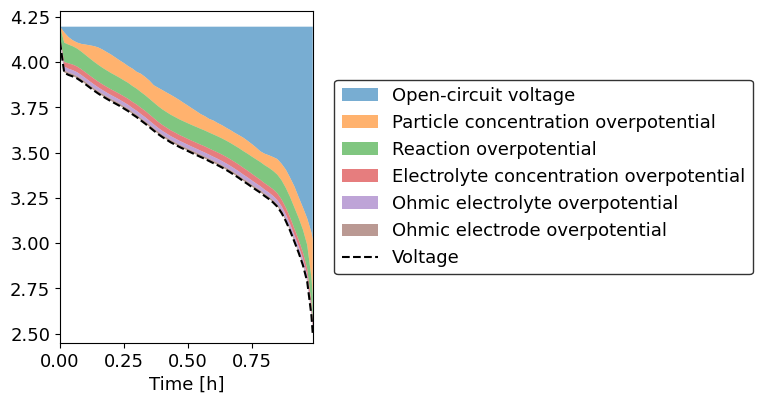

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [ ]:

pb.plot_voltage_components(
    Sol_0[0].cycles[0].steps[0])

In [ ]:
# Sol_0[0].cycles[-1]["Negative electrode stoichiometry"].entries
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[0].cycles[-1], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=124.73805456572224, description='t', max=129.72528427029596, min=124.7…

In [ ]:
Sol_0[-2].cycles

 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[-1].cycles[0], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=4.983306552856376, step=0.04983306552856376)…